# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [ ]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [ ]:
data = pd.read_csv('train.csv')

In [ ]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [ ]:
train.isna().sum()

id             0
keyword       44
location    1760
text           0
target         0
dtype: int64

In [ ]:
train.fillna(value="", inplace=True)

In [ ]:
test.isna().sum()

id            0
keyword      17
location    773
text          0
target        0
dtype: int64

In [ ]:
test.fillna(value="", inplace=True)

Проверка, что пропуски заполнились

In [ ]:
train.isna().sum().any()

False

In [ ]:
test.isna().sum().any()

False

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [ ]:
train['target'].value_counts()

0    3024
1    2305
Name: target, dtype: int64

В обучающей выборке не сбалансированное распределение классов

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [ ]:
popular_keywords = train['keyword'].value_counts()[:10]
popular_keywords

              44
damage        36
siren         35
wreckage      34
fatalities    33
deluge        31
refugees      30
derail        30
fear          30
tsunami       30
Name: keyword, dtype: int64

<Axes: xlabel='keyword', ylabel='Count'>

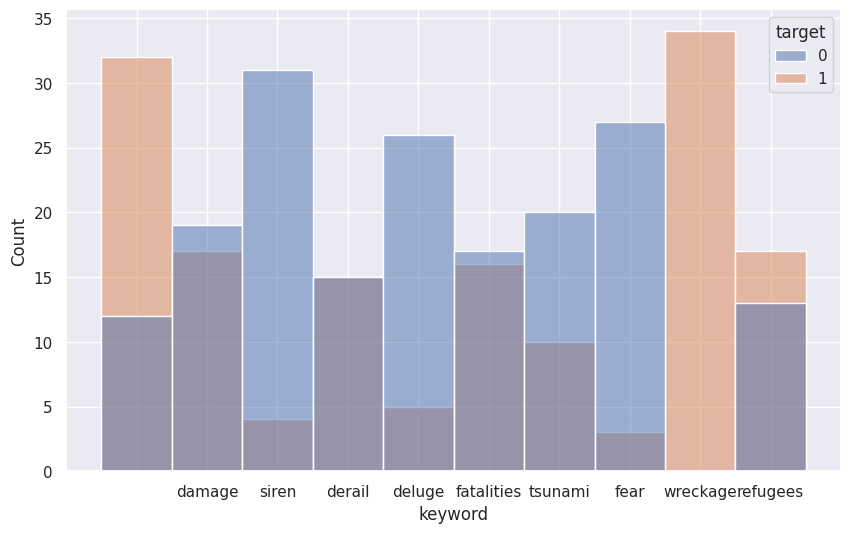

In [ ]:
sns.set(rc={'figure.figsize': (10, 6)})

sns.histplot(data=train.loc[train['keyword'].isin(popular_keywords.index)], x='keyword', hue='target')

**Выводы**:

Можно заметить, что, если в каком-то столбце доминирует класс, значит ключевое слово почти однозначно дает нам ответ на задачу

Например, по ключевому слову wreckage с почти полной уверенностью (99.999%) можно утверждать, что текст принадлежит к положительному классу

## Задание 3 (0.5 балла)

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [ ]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [ ]:
# TRAIN
train_new = train.copy()
train_new['text'] = train_new['keyword'] + ' ' + train_new['location'] + ' ' + train_new['text']
train_new.drop(['id', 'keyword', 'location'], inplace=True, axis=1)

# TEST
test_new = test.copy()
test_new['text'] = test_new['keyword'] + ' ' + test_new['location'] + ' ' + test_new['text']
test_new.drop(['id', 'keyword', 'location'], inplace=True, axis=1)

In [ ]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vec = CountVectorizer()
X = cnt_vec.fit_transform(train_new['text'])

In [ ]:
print("Размеры матрицы:")
X.toarray().shape

Размеры матрицы:


(5329, 18455)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось?

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [ ]:
cnt_vec.vocabulary_.keys()

In [ ]:
from string import punctuation, digits

In [ ]:
def contains_digit(s: str) -> bool:
    for element in digits:
        if element in s:
            return True
    return False

def contains_punctuation(s: str) -> bool:
    for element in punctuation:
        if element in s:
            return True
    return False

def is_hashtag(s: str) -> bool:
    return s.startswith('#')

def is_mention(s: str) -> bool:
    return s.startswith('@')

def investigate_vocabulary(vocabulary):
    cnt_digits = 0
    cnt_punct = 0
    cnt_hashtags = 0
    cnt_mentions = 0
    for token in vocabulary.keys():
        if contains_digit(token):
            cnt_digits += 1
        if contains_punctuation(token):
            cnt_punct += 1
        if is_hashtag(token):
            cnt_hashtags += 1
        if is_mention(token):
            cnt_mentions += 1

    print('With digit:      ', cnt_digits)
    print('With punctuation:', cnt_punct)
    print('Hashtags:        ', cnt_hashtags)
    print('Mentions:        ', cnt_mentions)

In [ ]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [ ]:
investigate_vocabulary(cnt_vec.vocabulary_)

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [ ]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

In [ ]:
help(TweetTokenizer)

In [ ]:
cnt_vec2 = CountVectorizer(tokenizer=TweetTokenizer().tokenize)

X_tweet = cnt_vec2.fit_transform(train_new['text'])
X_tweet.toarray().shape

(5329, 19670)

In [ ]:
investigate_vocabulary(cnt_vec2.vocabulary_)

With digit:       3939
With punctuation: 7338
Hashtags:         1470
Mentions:         1679


***Сравнение:***

Способ с токенизатором для твитом по показателям нахождения слов с цифрами, пунктуацией, хэштегами и упоминаниями показал более высокую точность (с учетом того что первый вариант решения вообще не нашел в тексте хэштеги и упоминания). В данной задаче очевидно, что нужно использовать 2 вариант

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно:

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [ ]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from string import ascii_letters

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')

In [ ]:
def contains_only_latin_letters(s: str) -> bool:
    for symbol in s:
        if symbol not in ascii_letters:
            return False
    return True

def is_emoji(s: str) -> bool:
    has_parenthese = False
    parentheses = ['(', ')']
    for symbol in s:
        if symbol in parentheses:
            has_parenthese = True
        if symbol not in punctuation:
            return False
    return has_parenthese

def is_hashtag(s: str) -> bool:
    return s[0] == '#' and contains_only_latin_letters(s[1:])

def custom_tokenizer(s: str) -> List[str]:
    s = s.lower()

    stemmer = SnowballStemmer("english")
    tw = TweetTokenizer()
    tokens = tw.tokenize(s)

    res_tokens = []
    for token in tokens:
        if (contains_only_latin_letters(token) or \
                            is_emoji(token) or  \
                            is_hashtag(token)) and \
                            token not in stopwords:
            res_tokens.append(stemmer.stem(token))
    return res_tokens

In [ ]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [ ]:
for text in train_new['text'][:10]:
    print(custom_tokenizer(text))

['bridg', 'ash', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']
['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']
['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']
['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class']
['wound', 'lake', 'highland', 'crack', 'path', 'wipe', 'morn', 'beach', 'run', 'surfac', 'wound', 'left', 'elbow', 'right', 'knee']
['airplan', 'somewher', 'expert', 'franc', 'begin', 'examin', 'airplan', 'debri', 'found', 'reunion', 'island', 'french', 'air', 'accid', 'expert', '#mlb']
['bloodi', 'isol', 'citi', 'world', 'perth', 'came', 'kill', 'indian', 'fun', 'video', 'smirk', 'remorseless', 'pakistani', 'killer', 'show', 'boast']
['burn', 'except', 'idk', 'realli', 'burn']
['destroy', '(', 'ask', ')', 'destroy', 'hous']
['wound', 'maracay', 'nirgua', 'venezuela', 'polic', 'offic', 'wound', 'suspect

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [ ]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)

bow_train = vectorizer.fit_transform(train_new['text'])  # bow — bag of words (мешок слов)
bow_test = vectorizer.transform(test_new['text'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


2. Обучите LogisticRegression на полученных признаках.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
y_train, y_test = train_new.target, test_new.target

In [ ]:
scaler = MaxAbsScaler()
bow_train = scaler.fit_transform(bow_train)
bow_test = scaler.transform(bow_test)

clf = LogisticRegression(max_iter=100, random_state=42)
clf.fit(bow_train, y_train)
pred = clf.predict(bow_test)

3. Посчитайте метрику f1-score на тестовых данных.

In [ ]:
from sklearn.metrics import f1_score

print('F1 score:', f1_score(y_test, pred))

F1 score: 0.7440310938367575


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()
vec_train = vec.fit_transform(train_new['text'])
print("Shape of train matrix =", vec_train.shape)
vec_test = vec.transform(test_new['text'])

scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

clf = LogisticRegression(max_iter=100, random_state=42)
clf.fit(vec_train, y_train)
pred_tfidf = clf.predict(vec_test)

print('F1 score:', f1_score(y_test, pred_tfidf))

Shape of train matrix = (5329, 18455)
F1 score: 0.7470651013874066


1. **Ответ:** качество модели с TF-IDF векторизатором немного увеличилось, то есть в рамках данной задаче важность слова конкретного текста играет (хоть и небольшую) роль при выдаче предсказаний.

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [ ]:
vec = TfidfVectorizer(max_df=0.9)
vec_train = vec.fit_transform(train_new['text'])
print("Shape of train matrix =", vec_train.shape)
vec_test = vec.transform(test_new['text'])

scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

clf = LogisticRegression(max_iter=100, random_state=42)
clf.fit(vec_train, y_train)
pred_tfidf = clf.predict(vec_test)

print('F1 score:', f1_score(y_test, pred_tfidf))

Shape of train matrix = (5329, 18455)
F1 score: 0.7470651013874066


2. **Ответ:** Ничего не изменилось, следовательно в матрице отсутсвуют значения, для которых df > 0.9

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества?

In [ ]:
vec = TfidfVectorizer(min_df=0.01, max_df=0.9)
vec_train = vec.fit_transform(train_new['text'])
print("Shape of train matrix =", vec_train.shape)
vec_test = vec.transform(test_new['text'])

scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

clf = LogisticRegression(max_iter=100, random_state=42)
clf.fit(vec_train, y_train)
pred_tfidf = clf.predict(vec_test)

print('F1 score:', f1_score(y_test, pred_tfidf))

Shape of train matrix = (5329, 171)
F1 score: 0.6632710809281268


3. **Ответ:** при ограничении нижней границы параметрами 0.1, 0.01, 0.001 также не удалось добиться улучшения качества модели

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

hash_vectorizer = HashingVectorizer(tokenizer=custom_tokenizer, n_features=5_000)

bow_train = hash_vectorizer.fit_transform(train_new['text'])  # bow — bag of words (мешок слов)
bow_test = hash_vectorizer.transform(test_new['text'])
scaler = MaxAbsScaler()
bow_train = scaler.fit_transform(bow_train)
bow_test = scaler.transform(bow_test)

clf = LogisticRegression(max_iter=100, random_state=42)
clf.fit(bow_train, y_train)
pred = clf.predict(bow_test)

print('F1 score:', f1_score(y_test, pred))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7329729729729729


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** модель с TF-IDF векторизатором показала самый высокий результатБ при котором f-мера достигала 75%

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [ ]:
vec = CountVectorizer(ngram_range=(1, 1))
vec_train = vec.fit_transform(train_new['text'])
print("Shape of train matrix =", vec_train.shape)
vec_test = vec.transform(test_new['text'])

scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

clf = LogisticRegression(max_iter=100, random_state=49)
clf.fit(vec_train, y_train)
pred = clf.predict(vec_test)

print('F1 score:', f1_score(y_test, pred))

Shape of train matrix = (5329, 18455)
F1 score: 0.7582781456953642
